In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter


import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

In [3]:
path = 'C:\\Users\\Elvemage\\Downloads\\'
df = pd.read_csv(path+'train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

In [4]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

In [5]:
x_train,x_test,y_train,y_test = train_test_split(X_norm,Y,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [6]:
anomaly = x_train.loc[np.ravel(y_train.index[np.where(y_train==1)])]
non_anomaly = x_train.loc[np.ravel(y_train.index[np.where(y_train==0)])]

yan = y_train.loc[np.ravel(y_train.index[np.where(y_train==1)])]
yna = y_train.loc[np.ravel(y_train.index[np.where(y_train==0)])]

In [7]:
na_used, x_trash, yna, y_trash = train_test_split(non_anomaly, yna, test_size = 0.75, random_state = 30)
x_train = pd.concat([na_used,anomaly],ignore_index = False)
y_train = pd.concat([yna,yan],ignore_index=False)

In [8]:
print('Resampled dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_test))
print('Resampled dataset shape %s' % Counter(y_val))

Resampled dataset shape Counter({0: 31514, 1: 13942})
Resampled dataset shape Counter({0: 26894, 1: 3106})
Resampled dataset shape Counter({0: 26950, 1: 3050})


In [9]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

In [10]:
def f1Score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [12]:
def choosing_threshold(y_true,y_prob,threshold_list):
    y_hat = []
    precision = []
    recall = []
    f1 = []
    y_h = []
    for threshold in threshold_list:
        for i in range(len(y_true)):
            if y_prob[i]>threshold:
                y_hat.append(1)
            else:
                y_hat.append(0)
        precision.append(precision_score(y_true,y_hat))
        recall.append(recall_score(y_true,y_hat))
        f1.append(f1_score(y_true,y_hat))
        y_h.append(y_hat)
        y_hat = []
    return(precision,recall,f1,y_h)           

In [13]:
def predict_threshold(y_prob,threshold):
    y_hat = []
    for i in range(len(y_prob)):
        if y_prob[i]>threshold:
            y_hat.append(1)
        else:
            y_hat.append(0)
    return y_hat

In [14]:
model = models.Sequential()
model.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,),kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [15]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(x_data[0],y_data[0],epochs = 2000, validation_data =(x_data[1],y_data[1]),verbose = 0)

Instructions for updating:
Use tf.cast instead.


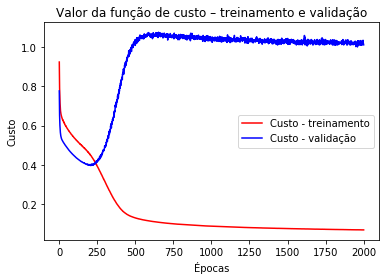

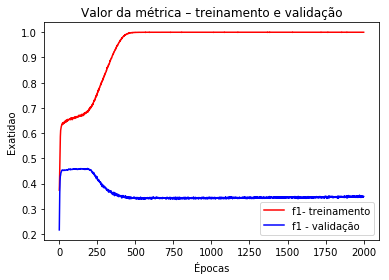

In [16]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

Normalized confusion matrix
[[0.74823748 0.25176252]
 [0.31540984 0.68459016]]
Normalized confusion matrix
[[0.75280148 0.24719852]
 [0.32196721 0.67803279]]
Normalized confusion matrix
[[0.75680891 0.24319109]
 [0.32786885 0.67213115]]
Normalized confusion matrix
[[0.76033395 0.23966605]
 [0.33081967 0.66918033]]
Normalized confusion matrix
[[0.76411874 0.23588126]
 [0.3347541  0.6652459 ]]
Normalized confusion matrix
[[0.76745826 0.23254174]
 [0.33934426 0.66065574]]
Normalized confusion matrix
[[0.7703525  0.2296475 ]
 [0.34196721 0.65803279]]
Normalized confusion matrix
[[0.77369202 0.22630798]
 [0.3442623  0.6557377 ]]
Normalized confusion matrix
[[0.77602968 0.22397032]
 [0.34688525 0.65311475]]
Normalized confusion matrix
[[0.77851577 0.22148423]
 [0.34918033 0.65081967]]
Normalized confusion matrix
[[0.78089054 0.21910946]
 [0.35344262 0.64655738]]
Normalized confusion matrix
[[0.78359926 0.21640074]
 [0.35639344 0.64360656]]
Normalized confusion matrix
[[0.78564007 0.21435993]

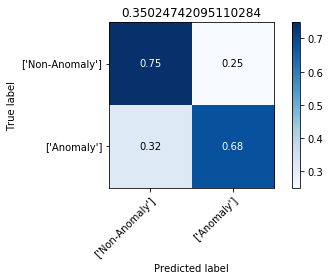

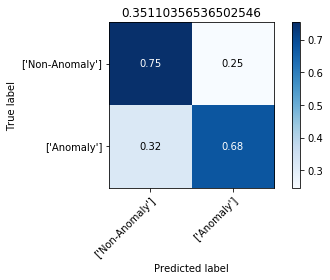

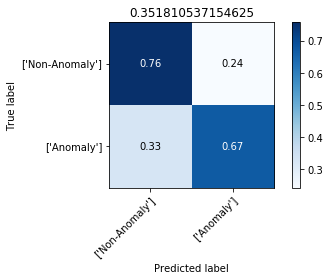

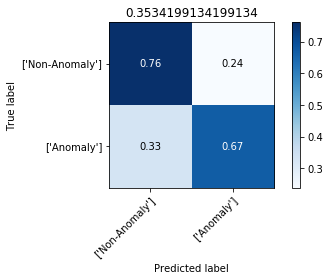

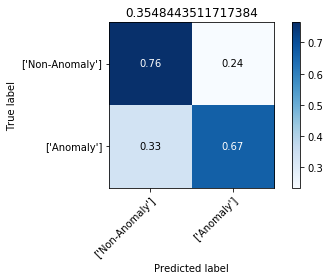

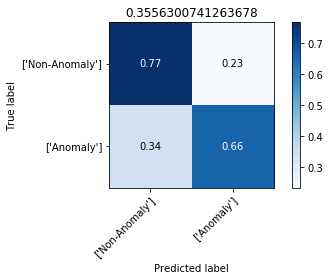

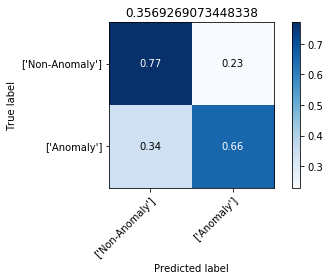

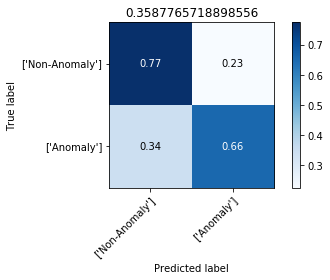

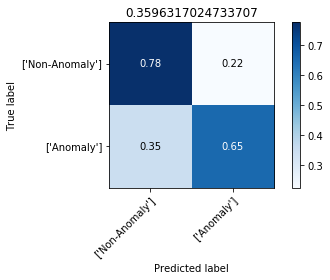

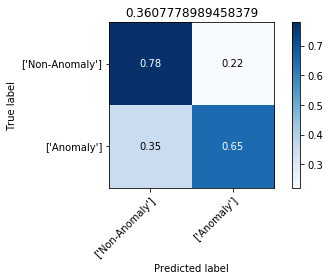

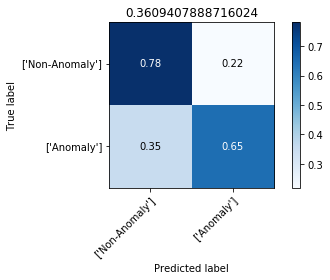

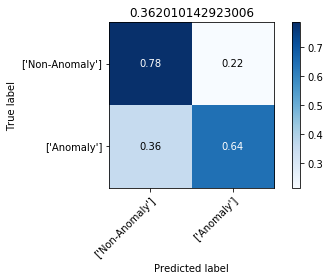

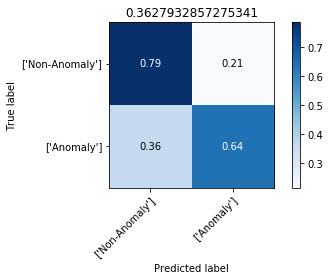

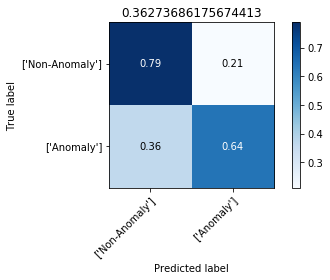

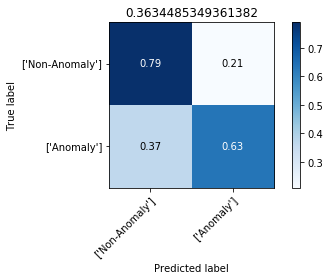

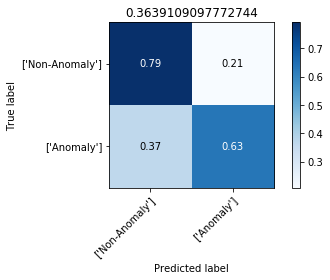

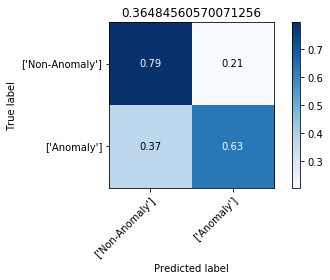

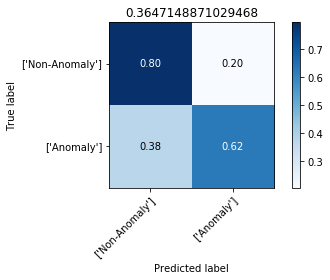

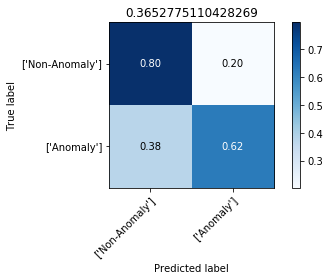

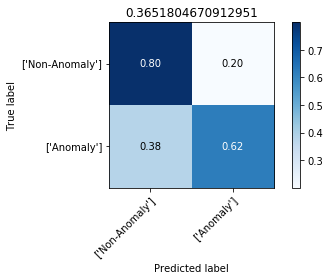

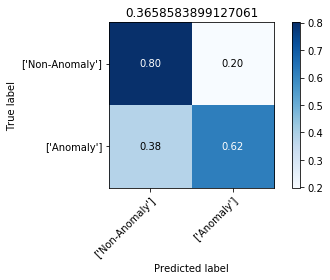

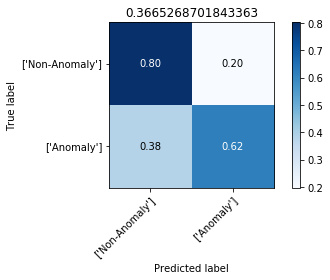

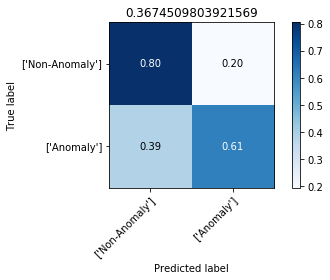

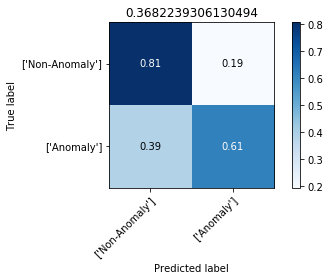

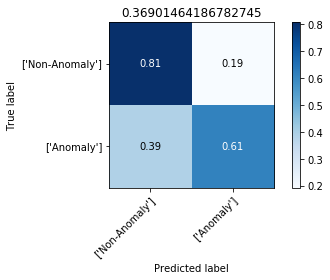

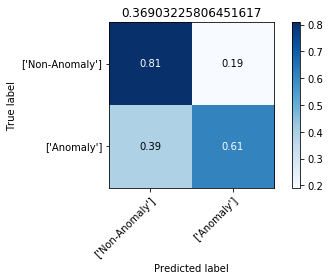

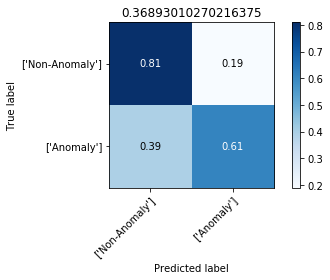

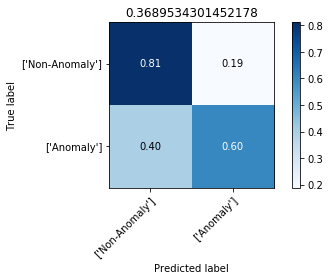

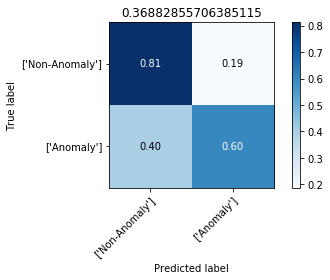

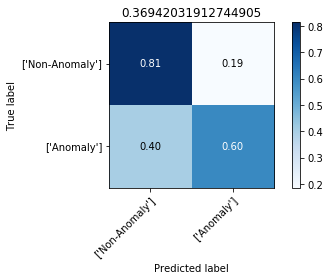

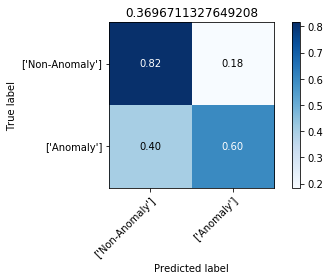

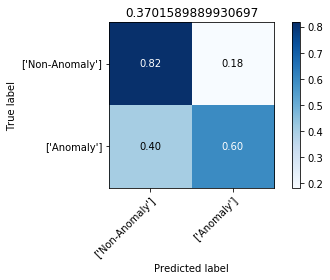

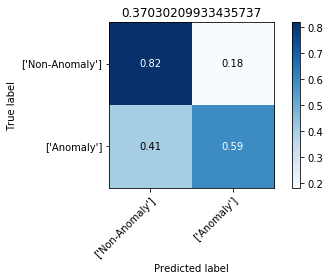

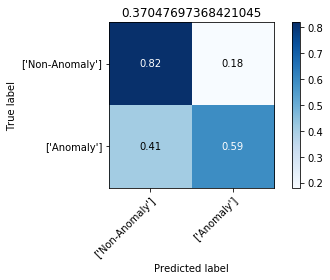

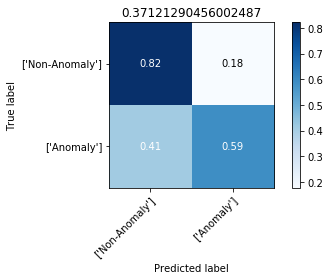

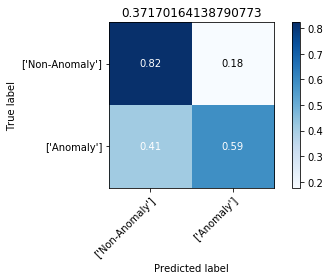

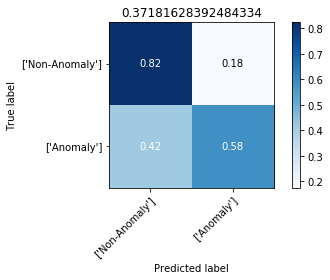

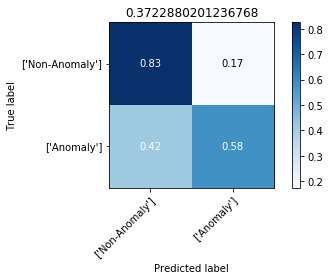

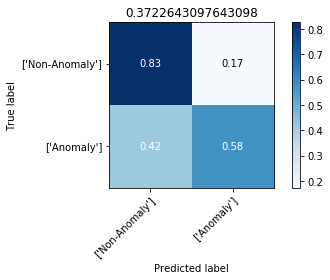

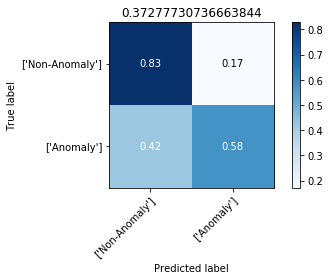

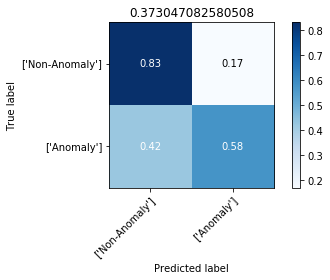

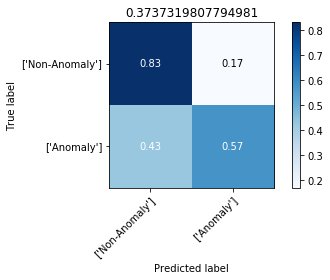

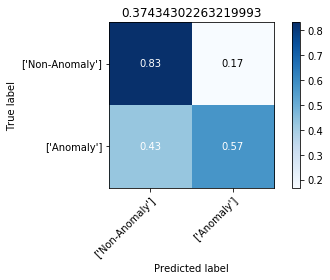

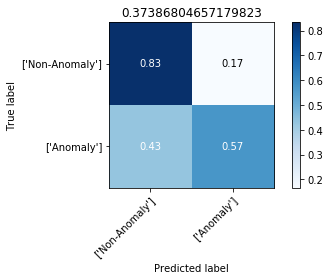

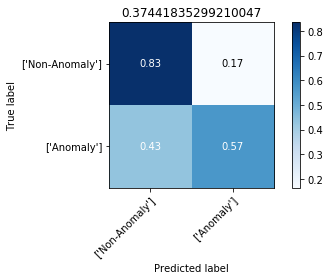

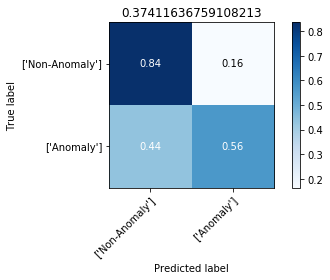

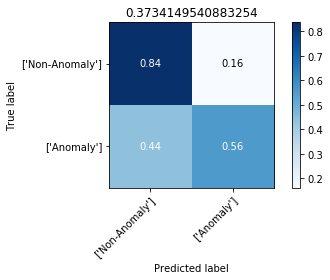

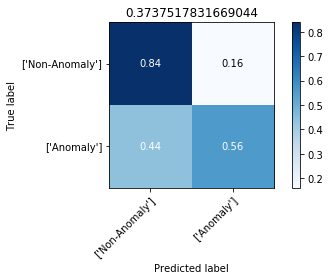

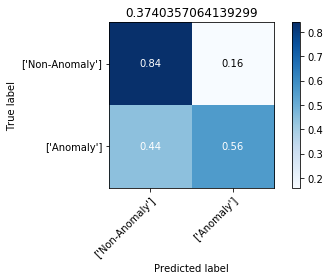

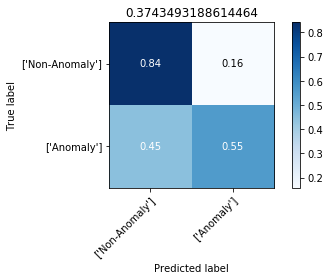

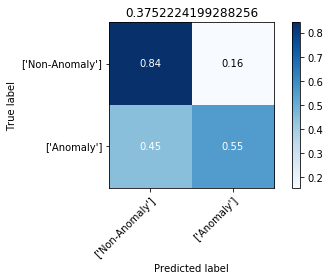

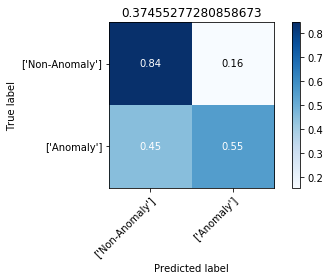

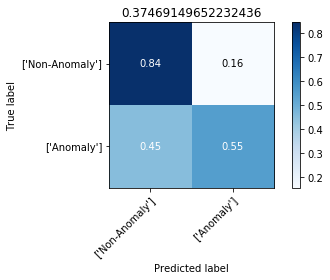

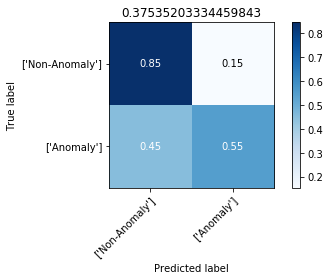

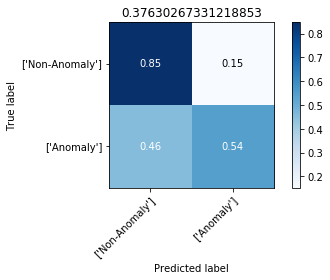

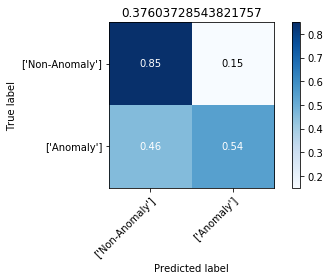

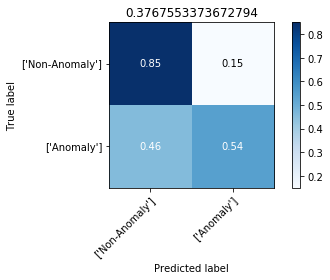

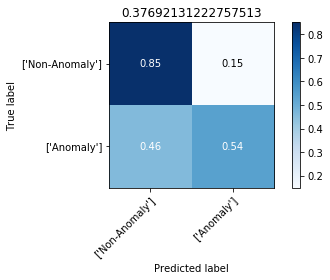

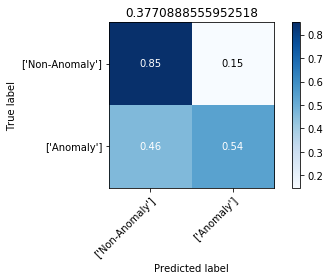

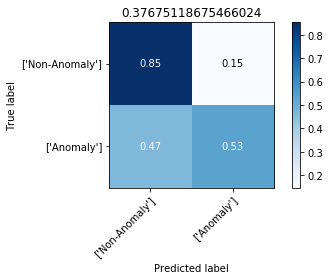

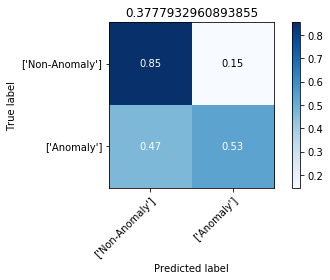

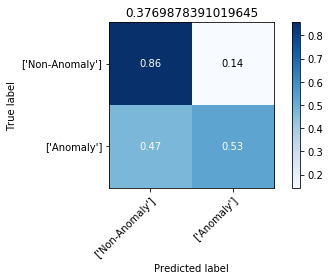

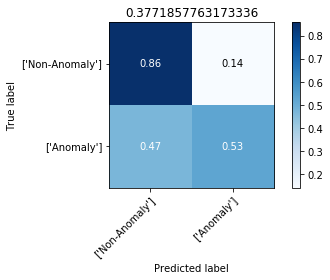

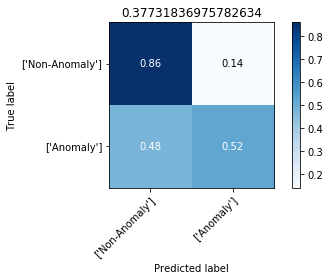

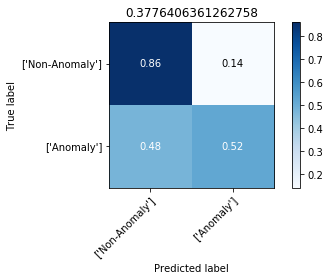

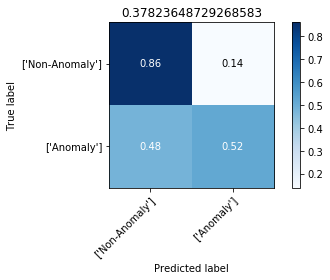

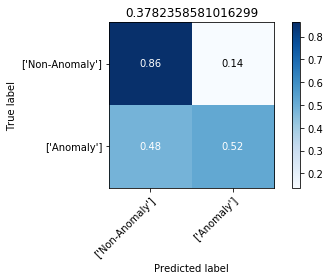

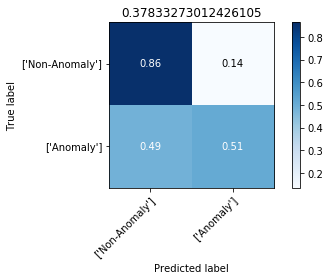

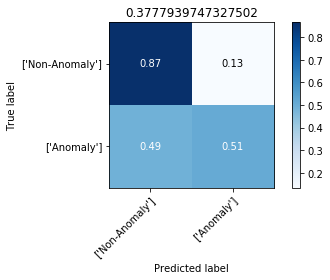

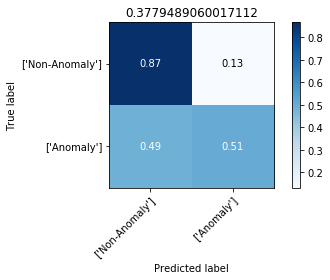

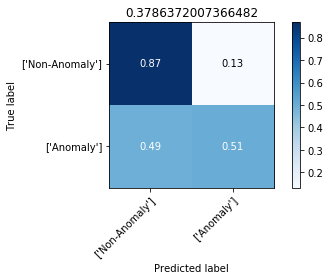

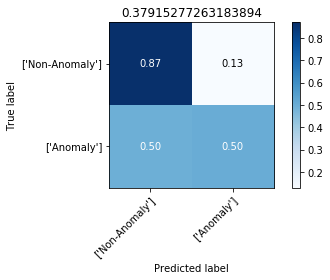

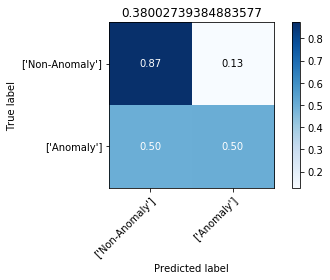

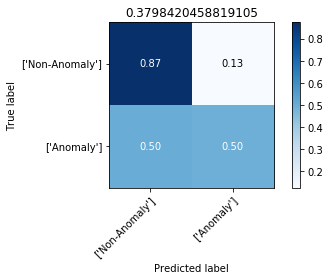

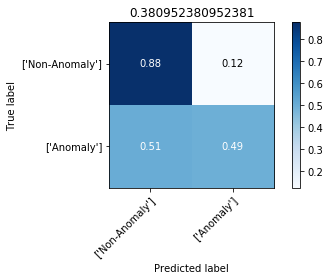

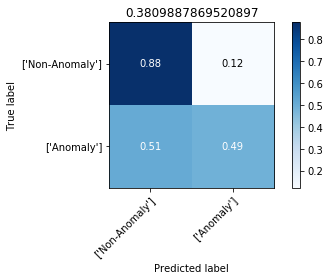

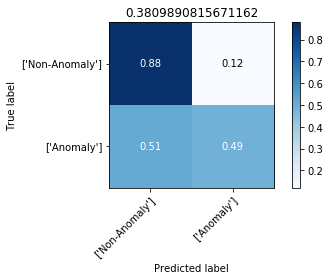

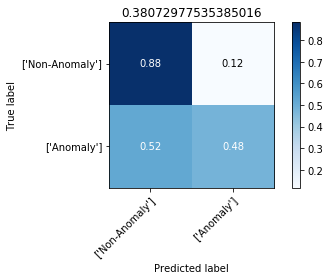

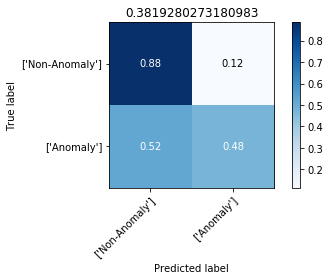

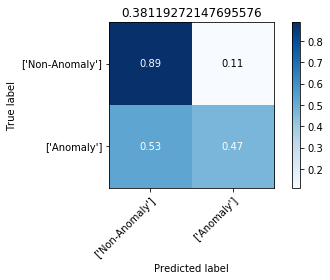

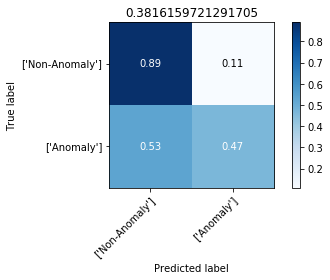

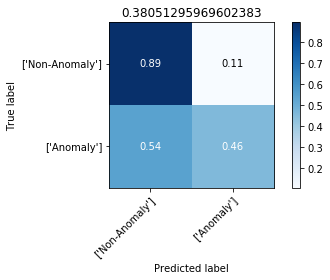

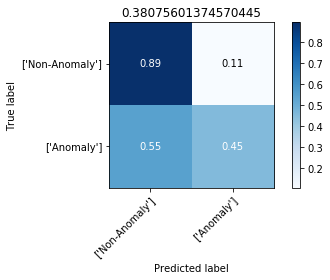

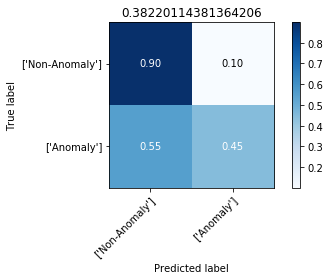

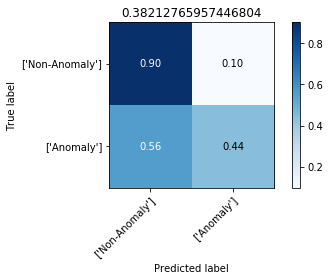

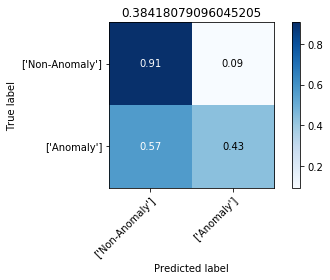

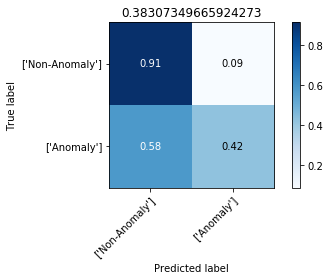

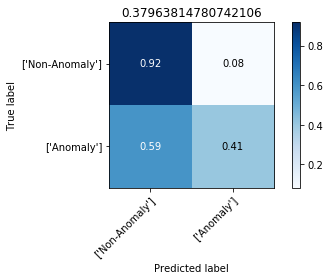

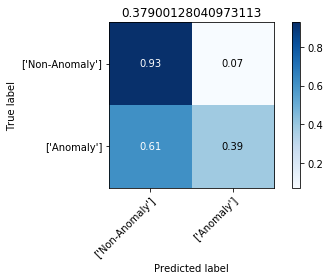

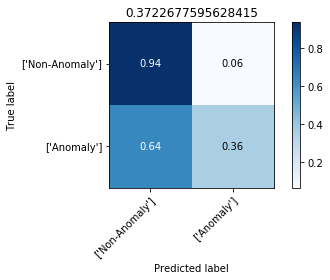

In [17]:
prob = np.ravel(model.predict(x_data[1]))
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[1],prob,threshold_list)

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[1], yprob[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

Normalized confusion matrix
[[1.         0.        ]
 [0.09654282 0.90345718]]
Normalized confusion matrix
[[0.90623377 0.09376623]
 [0.5652459  0.4347541 ]]
Normalized confusion matrix
[[0.90678218 0.09321782]
 [0.58403091 0.41596909]]


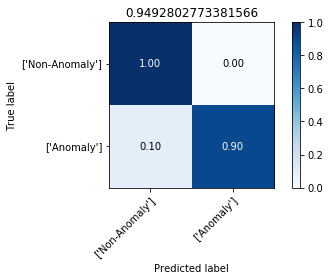

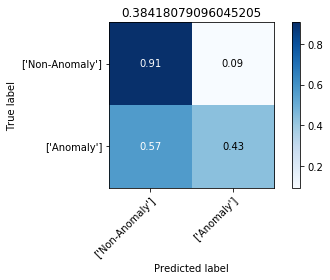

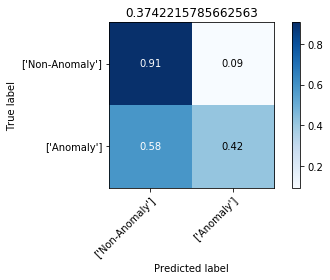

In [18]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])),
                                   threshold_list[f1.index(max(f1))]))

for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)

In [19]:
K.clear_session()

In [20]:
model = models.Sequential()
model.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [21]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(x_data[0],y_data[0],epochs = 2000, validation_data =(x_data[1],y_data[1]))

Train on 45456 samples, validate on 30000 samples
Epoch 1/2000
45456/45456 [==============================] - 5s 115us/step - loss: 0.7947 - f1Score: 0.3915 - val_loss: 0.6309 - val_f1Score: 0.2462
Epoch 2/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.6893 - f1Score: 0.4340 - val_loss: 0.5470 - val_f1Score: 0.3155
Epoch 3/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.6425 - f1Score: 0.4744 - val_loss: 0.5040 - val_f1Score: 0.3593
Epoch 4/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.6121 - f1Score: 0.5125 - val_loss: 0.4776 - val_f1Score: 0.3895
Epoch 5/2000
45456/45456 [==============================] - 4s 87us/step - loss: 0.5921 - f1Score: 0.5419 - val_loss: 0.4603 - val_f1Score: 0.4057
Epoch 6/2000
45456/45456 [==============================] - 4s 87us/step - loss: 0.5739 - f1Score: 0.5664 - val_loss: 0.4480 - val_f1Score: 0.4195
Epoch 7/2000
45456/45456 [==============================] - 4s 91us

45456/45456 [==============================] - 4s 91us/step - loss: 0.4871 - f1Score: 0.6531 - val_loss: 0.3889 - val_f1Score: 0.4508
Epoch 57/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.4863 - f1Score: 0.6527 - val_loss: 0.3885 - val_f1Score: 0.4509
Epoch 58/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.4853 - f1Score: 0.6533 - val_loss: 0.3880 - val_f1Score: 0.4503
Epoch 59/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.4844 - f1Score: 0.6537 - val_loss: 0.3876 - val_f1Score: 0.4503
Epoch 60/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.4836 - f1Score: 0.6534 - val_loss: 0.3873 - val_f1Score: 0.4502
Epoch 61/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.4828 - f1Score: 0.6554 - val_loss: 0.3870 - val_f1Score: 0.4504
Epoch 62/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.4824 - f1Score: 0.6508 - val_loss: 0.3865 

45456/45456 [==============================] - 4s 93us/step - loss: 0.4559 - f1Score: 0.6640 - val_loss: 0.3692 - val_f1Score: 0.4512
Epoch 112/2000
45456/45456 [==============================] - 4s 88us/step - loss: 0.4548 - f1Score: 0.6655 - val_loss: 0.3690 - val_f1Score: 0.4509
Epoch 113/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.4551 - f1Score: 0.6668 - val_loss: 0.3687 - val_f1Score: 0.4504
Epoch 114/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.4539 - f1Score: 0.6684 - val_loss: 0.3684 - val_f1Score: 0.4509
Epoch 115/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.4536 - f1Score: 0.6657 - val_loss: 0.3680 - val_f1Score: 0.4505
Epoch 116/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.4533 - f1Score: 0.6662 - val_loss: 0.3675 - val_f1Score: 0.4510
Epoch 117/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.4535 - f1Score: 0.6647 - val_loss: 0

45456/45456 [==============================] - 4s 90us/step - loss: 0.4282 - f1Score: 0.6816 - val_loss: 0.3567 - val_f1Score: 0.4492
Epoch 167/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.4279 - f1Score: 0.6822 - val_loss: 0.3560 - val_f1Score: 0.4498
Epoch 168/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.4277 - f1Score: 0.6792 - val_loss: 0.3559 - val_f1Score: 0.4495
Epoch 169/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.4263 - f1Score: 0.6832 - val_loss: 0.3562 - val_f1Score: 0.4486
Epoch 170/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.4262 - f1Score: 0.6804 - val_loss: 0.3562 - val_f1Score: 0.4490
Epoch 171/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.4256 - f1Score: 0.6835 - val_loss: 0.3558 - val_f1Score: 0.4494
Epoch 172/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.4255 - f1Score: 0.6835 - val_loss: 0

45456/45456 [==============================] - 4s 92us/step - loss: 0.3912 - f1Score: 0.7102 - val_loss: 0.3571 - val_f1Score: 0.4365
Epoch 222/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.3906 - f1Score: 0.7117 - val_loss: 0.3580 - val_f1Score: 0.4351
Epoch 223/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.3900 - f1Score: 0.7148 - val_loss: 0.3571 - val_f1Score: 0.4351
Epoch 224/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.3896 - f1Score: 0.7125 - val_loss: 0.3583 - val_f1Score: 0.4352
Epoch 225/2000
45456/45456 [==============================] - 4s 88us/step - loss: 0.3875 - f1Score: 0.7146 - val_loss: 0.3580 - val_f1Score: 0.4339
Epoch 226/2000
45456/45456 [==============================] - 4s 88us/step - loss: 0.3878 - f1Score: 0.7132 - val_loss: 0.3582 - val_f1Score: 0.4331
Epoch 227/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.3868 - f1Score: 0.7175 - val_loss: 0

45456/45456 [==============================] - 4s 91us/step - loss: 0.3313 - f1Score: 0.7698 - val_loss: 0.3947 - val_f1Score: 0.3968
Epoch 277/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.3295 - f1Score: 0.7703 - val_loss: 0.3989 - val_f1Score: 0.3989
Epoch 278/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.3280 - f1Score: 0.7763 - val_loss: 0.3977 - val_f1Score: 0.3981
Epoch 279/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.3261 - f1Score: 0.7738 - val_loss: 0.4000 - val_f1Score: 0.3983
Epoch 280/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.3267 - f1Score: 0.7735 - val_loss: 0.4031 - val_f1Score: 0.3951
Epoch 281/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.3245 - f1Score: 0.7792 - val_loss: 0.3982 - val_f1Score: 0.3920
Epoch 282/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.3226 - f1Score: 0.7790 - val_loss: 0

45456/45456 [==============================] - 4s 96us/step - loss: 0.2487 - f1Score: 0.8436 - val_loss: 0.4949 - val_f1Score: 0.3687
Epoch 332/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.2471 - f1Score: 0.8461 - val_loss: 0.4946 - val_f1Score: 0.3652
Epoch 333/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.2467 - f1Score: 0.8447 - val_loss: 0.5026 - val_f1Score: 0.3655
Epoch 334/2000
45456/45456 [==============================] - 5s 100us/step - loss: 0.2447 - f1Score: 0.8480 - val_loss: 0.5042 - val_f1Score: 0.3648
Epoch 335/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.2428 - f1Score: 0.8485 - val_loss: 0.5030 - val_f1Score: 0.3647
Epoch 336/2000
45456/45456 [==============================] - 4s 96us/step - loss: 0.2425 - f1Score: 0.8496 - val_loss: 0.5054 - val_f1Score: 0.3642
Epoch 337/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.2402 - f1Score: 0.8511 - val_loss: 

45456/45456 [==============================] - 4s 97us/step - loss: 0.1593 - f1Score: 0.9213 - val_loss: 0.6886 - val_f1Score: 0.3471
Epoch 387/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.1580 - f1Score: 0.9219 - val_loss: 0.6974 - val_f1Score: 0.3449
Epoch 388/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.1553 - f1Score: 0.9237 - val_loss: 0.6928 - val_f1Score: 0.3458
Epoch 389/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.1556 - f1Score: 0.9259 - val_loss: 0.6998 - val_f1Score: 0.3450
Epoch 390/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.1531 - f1Score: 0.9259 - val_loss: 0.7094 - val_f1Score: 0.3461
Epoch 391/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.1515 - f1Score: 0.9292 - val_loss: 0.7146 - val_f1Score: 0.3451
Epoch 392/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.1496 - f1Score: 0.9299 - val_loss: 0

45456/45456 [==============================] - 4s 92us/step - loss: 0.0852 - f1Score: 0.9843 - val_loss: 0.9869 - val_f1Score: 0.3330
Epoch 442/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0843 - f1Score: 0.9844 - val_loss: 0.9943 - val_f1Score: 0.3309
Epoch 443/2000
45456/45456 [==============================] - 4s 96us/step - loss: 0.0831 - f1Score: 0.9865 - val_loss: 0.9898 - val_f1Score: 0.3321
Epoch 444/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0819 - f1Score: 0.9853 - val_loss: 1.0065 - val_f1Score: 0.3318
Epoch 445/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0813 - f1Score: 0.9866 - val_loss: 1.0000 - val_f1Score: 0.3319
Epoch 446/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0798 - f1Score: 0.9884 - val_loss: 1.0120 - val_f1Score: 0.3324
Epoch 447/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0791 - f1Score: 0.9889 - val_loss: 1

45456/45456 [==============================] - 4s 89us/step - loss: 0.0513 - f1Score: 0.9997 - val_loss: 1.2247 - val_f1Score: 0.3306
Epoch 497/2000
45456/45456 [==============================] - 5s 103us/step - loss: 0.0508 - f1Score: 1.0000 - val_loss: 1.2272 - val_f1Score: 0.3318
Epoch 498/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0505 - f1Score: 0.9998 - val_loss: 1.2385 - val_f1Score: 0.3301
Epoch 499/2000
45456/45456 [==============================] - 4s 88us/step - loss: 0.0501 - f1Score: 0.9999 - val_loss: 1.2292 - val_f1Score: 0.3308
Epoch 500/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0499 - f1Score: 0.9999 - val_loss: 1.2302 - val_f1Score: 0.3314
Epoch 501/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0495 - f1Score: 0.9999 - val_loss: 1.2354 - val_f1Score: 0.3311
Epoch 502/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0493 - f1Score: 1.0000 - val_loss: 

45456/45456 [==============================] - 4s 92us/step - loss: 0.0395 - f1Score: 1.0000 - val_loss: 1.3347 - val_f1Score: 0.3293
Epoch 552/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0395 - f1Score: 1.0000 - val_loss: 1.3398 - val_f1Score: 0.3313
Epoch 553/2000
45456/45456 [==============================] - 4s 97us/step - loss: 0.0392 - f1Score: 1.0000 - val_loss: 1.3405 - val_f1Score: 0.3316
Epoch 554/2000
45456/45456 [==============================] - 4s 94us/step - loss: 0.0391 - f1Score: 1.0000 - val_loss: 1.3421 - val_f1Score: 0.3306
Epoch 555/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0390 - f1Score: 1.0000 - val_loss: 1.3406 - val_f1Score: 0.3314
Epoch 556/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0388 - f1Score: 1.0000 - val_loss: 1.3455 - val_f1Score: 0.3304
Epoch 557/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0388 - f1Score: 1.0000 - val_loss: 1

45456/45456 [==============================] - 4s 94us/step - loss: 0.0337 - f1Score: 1.0000 - val_loss: 1.3836 - val_f1Score: 0.3319
Epoch 607/2000
45456/45456 [==============================] - 4s 94us/step - loss: 0.0336 - f1Score: 1.0000 - val_loss: 1.3889 - val_f1Score: 0.3324
Epoch 608/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0335 - f1Score: 1.0000 - val_loss: 1.3834 - val_f1Score: 0.3329
Epoch 609/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0335 - f1Score: 1.0000 - val_loss: 1.3829 - val_f1Score: 0.3327
Epoch 610/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0333 - f1Score: 0.9996 - val_loss: 1.3893 - val_f1Score: 0.3333
Epoch 611/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0333 - f1Score: 1.0000 - val_loss: 1.3845 - val_f1Score: 0.3333
Epoch 612/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0332 - f1Score: 1.0000 - val_loss: 1

45456/45456 [==============================] - 4s 89us/step - loss: 0.0298 - f1Score: 1.0000 - val_loss: 1.4052 - val_f1Score: 0.3327
Epoch 662/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0297 - f1Score: 1.0000 - val_loss: 1.4047 - val_f1Score: 0.3315
Epoch 663/2000
45456/45456 [==============================] - 5s 101us/step - loss: 0.0296 - f1Score: 1.0000 - val_loss: 1.4034 - val_f1Score: 0.3327
Epoch 664/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0296 - f1Score: 1.0000 - val_loss: 1.4055 - val_f1Score: 0.3325
Epoch 665/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0295 - f1Score: 0.9993 - val_loss: 1.4049 - val_f1Score: 0.3328
Epoch 666/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0295 - f1Score: 1.0000 - val_loss: 1.4051 - val_f1Score: 0.3336
Epoch 667/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0295 - f1Score: 1.0000 - val_loss: 

45456/45456 [==============================] - 4s 97us/step - loss: 0.0268 - f1Score: 1.0000 - val_loss: 1.4068 - val_f1Score: 0.3336
Epoch 717/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0268 - f1Score: 1.0000 - val_loss: 1.4105 - val_f1Score: 0.3343
Epoch 718/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0268 - f1Score: 1.0000 - val_loss: 1.4098 - val_f1Score: 0.3339
Epoch 719/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0267 - f1Score: 1.0000 - val_loss: 1.4094 - val_f1Score: 0.3343
Epoch 720/2000
45456/45456 [==============================] - 4s 99us/step - loss: 0.0267 - f1Score: 1.0000 - val_loss: 1.4082 - val_f1Score: 0.3343
Epoch 721/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0267 - f1Score: 1.0000 - val_loss: 1.4091 - val_f1Score: 0.3350
Epoch 722/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0266 - f1Score: 1.0000 - val_loss: 1

45456/45456 [==============================] - 4s 89us/step - loss: 0.0245 - f1Score: 1.0000 - val_loss: 1.4081 - val_f1Score: 0.3356
Epoch 772/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0245 - f1Score: 1.0000 - val_loss: 1.4092 - val_f1Score: 0.3366
Epoch 773/2000
45456/45456 [==============================] - 5s 101us/step - loss: 0.0245 - f1Score: 1.0000 - val_loss: 1.4083 - val_f1Score: 0.3356
Epoch 774/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0244 - f1Score: 1.0000 - val_loss: 1.4112 - val_f1Score: 0.3352
Epoch 775/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0244 - f1Score: 1.0000 - val_loss: 1.4095 - val_f1Score: 0.3359
Epoch 776/2000
45456/45456 [==============================] - 5s 101us/step - loss: 0.0243 - f1Score: 1.0000 - val_loss: 1.4100 - val_f1Score: 0.3362
Epoch 777/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0243 - f1Score: 1.0000 - val_loss:

45456/45456 [==============================] - 4s 90us/step - loss: 0.0227 - f1Score: 1.0000 - val_loss: 1.4072 - val_f1Score: 0.3358
Epoch 827/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0226 - f1Score: 1.0000 - val_loss: 1.4067 - val_f1Score: 0.3351
Epoch 828/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0226 - f1Score: 1.0000 - val_loss: 1.4081 - val_f1Score: 0.3350
Epoch 829/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0226 - f1Score: 1.0000 - val_loss: 1.4076 - val_f1Score: 0.3352
Epoch 830/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0226 - f1Score: 1.0000 - val_loss: 1.4085 - val_f1Score: 0.3351
Epoch 831/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0225 - f1Score: 1.0000 - val_loss: 1.4073 - val_f1Score: 0.3356
Epoch 832/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0225 - f1Score: 1.0000 - val_loss: 1

45456/45456 [==============================] - 4s 88us/step - loss: 0.0211 - f1Score: 1.0000 - val_loss: 1.4046 - val_f1Score: 0.3366
Epoch 882/2000
45456/45456 [==============================] - 4s 97us/step - loss: 0.0211 - f1Score: 1.0000 - val_loss: 1.4048 - val_f1Score: 0.3370
Epoch 883/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0211 - f1Score: 1.0000 - val_loss: 1.4034 - val_f1Score: 0.3370
Epoch 884/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0211 - f1Score: 1.0000 - val_loss: 1.4049 - val_f1Score: 0.3349
Epoch 885/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0210 - f1Score: 1.0000 - val_loss: 1.4042 - val_f1Score: 0.3362
Epoch 886/2000
45456/45456 [==============================] - 5s 101us/step - loss: 0.0210 - f1Score: 1.0000 - val_loss: 1.4054 - val_f1Score: 0.3368
Epoch 887/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0210 - f1Score: 1.0000 - val_loss: 

45456/45456 [==============================] - 3s 74us/step - loss: 0.0199 - f1Score: 1.0000 - val_loss: 1.4026 - val_f1Score: 0.3363
Epoch 937/2000
45456/45456 [==============================] - 3s 75us/step - loss: 0.0199 - f1Score: 1.0000 - val_loss: 1.4014 - val_f1Score: 0.3357
Epoch 938/2000
45456/45456 [==============================] - 4s 83us/step - loss: 0.0198 - f1Score: 1.0000 - val_loss: 1.4022 - val_f1Score: 0.3368
Epoch 939/2000
45456/45456 [==============================] - 3s 75us/step - loss: 0.0198 - f1Score: 1.0000 - val_loss: 1.4014 - val_f1Score: 0.3355
Epoch 940/2000
45456/45456 [==============================] - 3s 76us/step - loss: 0.0198 - f1Score: 1.0000 - val_loss: 1.4007 - val_f1Score: 0.3365
Epoch 941/2000
45456/45456 [==============================] - 4s 96us/step - loss: 0.0198 - f1Score: 1.0000 - val_loss: 1.4013 - val_f1Score: 0.3367
Epoch 942/2000
45456/45456 [==============================] - 4s 97us/step - loss: 0.0198 - f1Score: 1.0000 - val_loss: 1

45456/45456 [==============================] - 4s 96us/step - loss: 0.0188 - f1Score: 1.0000 - val_loss: 1.4001 - val_f1Score: 0.3360
Epoch 992/2000
45456/45456 [==============================] - 4s 94us/step - loss: 0.0188 - f1Score: 1.0000 - val_loss: 1.4021 - val_f1Score: 0.3360
Epoch 993/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0187 - f1Score: 1.0000 - val_loss: 1.4008 - val_f1Score: 0.3358
Epoch 994/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0187 - f1Score: 1.0000 - val_loss: 1.4010 - val_f1Score: 0.3353
Epoch 995/2000
45456/45456 [==============================] - 4s 99us/step - loss: 0.0187 - f1Score: 1.0000 - val_loss: 1.4014 - val_f1Score: 0.3354
Epoch 996/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0187 - f1Score: 1.0000 - val_loss: 1.4015 - val_f1Score: 0.3360
Epoch 997/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0186 - f1Score: 1.0000 - val_loss: 1

Epoch 1046/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0178 - f1Score: 1.0000 - val_loss: 1.3976 - val_f1Score: 0.3357
Epoch 1047/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0178 - f1Score: 1.0000 - val_loss: 1.4011 - val_f1Score: 0.3353
Epoch 1048/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0178 - f1Score: 1.0000 - val_loss: 1.3978 - val_f1Score: 0.3359
Epoch 1049/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0178 - f1Score: 1.0000 - val_loss: 1.3999 - val_f1Score: 0.3357
Epoch 1050/2000
45456/45456 [==============================] - 4s 95us/step - loss: 0.0178 - f1Score: 0.9993 - val_loss: 1.3983 - val_f1Score: 0.3360
Epoch 1051/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0177 - f1Score: 1.0000 - val_loss: 1.3993 - val_f1Score: 0.3359
Epoch 1052/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0177 - f1Score

45456/45456 [==============================] - 4s 95us/step - loss: 0.0170 - f1Score: 1.0000 - val_loss: 1.3985 - val_f1Score: 0.3365
Epoch 1101/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0170 - f1Score: 1.0000 - val_loss: 1.3977 - val_f1Score: 0.3361
Epoch 1102/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0170 - f1Score: 1.0000 - val_loss: 1.3979 - val_f1Score: 0.3363
Epoch 1103/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0169 - f1Score: 1.0000 - val_loss: 1.3976 - val_f1Score: 0.3363
Epoch 1104/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0170 - f1Score: 1.0000 - val_loss: 1.3977 - val_f1Score: 0.3355
Epoch 1105/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0170 - f1Score: 1.0000 - val_loss: 1.3987 - val_f1Score: 0.3352
Epoch 1106/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0169 - f1Score: 1.0000 - val_l

Epoch 1155/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0162 - f1Score: 1.0000 - val_loss: 1.3965 - val_f1Score: 0.3359
Epoch 1156/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0163 - f1Score: 1.0000 - val_loss: 1.3975 - val_f1Score: 0.3361
Epoch 1157/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0162 - f1Score: 1.0000 - val_loss: 1.3960 - val_f1Score: 0.3359
Epoch 1158/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0162 - f1Score: 1.0000 - val_loss: 1.3971 - val_f1Score: 0.3357
Epoch 1159/2000
45456/45456 [==============================] - 4s 95us/step - loss: 0.0162 - f1Score: 1.0000 - val_loss: 1.3972 - val_f1Score: 0.3361
Epoch 1160/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0163 - f1Score: 1.0000 - val_loss: 1.3978 - val_f1Score: 0.3356
Epoch 1161/2000
45456/45456 [==============================] - 4s 97us/step - loss: 0.0162 - f1Score

45456/45456 [==============================] - 4s 90us/step - loss: 0.0156 - f1Score: 1.0000 - val_loss: 1.3965 - val_f1Score: 0.3358
Epoch 1210/2000
45456/45456 [==============================] - 4s 99us/step - loss: 0.0156 - f1Score: 0.9993 - val_loss: 1.3974 - val_f1Score: 0.3359
Epoch 1211/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0156 - f1Score: 1.0000 - val_loss: 1.3975 - val_f1Score: 0.3360
Epoch 1212/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0156 - f1Score: 1.0000 - val_loss: 1.3960 - val_f1Score: 0.3363
Epoch 1213/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0156 - f1Score: 1.0000 - val_loss: 1.3966 - val_f1Score: 0.3358
Epoch 1214/2000
45456/45456 [==============================] - 5s 101us/step - loss: 0.0156 - f1Score: 1.0000 - val_loss: 1.3965 - val_f1Score: 0.3371
Epoch 1215/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0156 - f1Score: 1.0000 - val_

Epoch 1264/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0151 - f1Score: 1.0000 - val_loss: 1.3962 - val_f1Score: 0.3368
Epoch 1265/2000
45456/45456 [==============================] - 4s 94us/step - loss: 0.0150 - f1Score: 1.0000 - val_loss: 1.3949 - val_f1Score: 0.3368
Epoch 1266/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0150 - f1Score: 1.0000 - val_loss: 1.3972 - val_f1Score: 0.3373
Epoch 1267/2000
45456/45456 [==============================] - 4s 96us/step - loss: 0.0150 - f1Score: 1.0000 - val_loss: 1.3972 - val_f1Score: 0.3364
Epoch 1268/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0150 - f1Score: 1.0000 - val_loss: 1.3966 - val_f1Score: 0.3372
Epoch 1269/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0150 - f1Score: 1.0000 - val_loss: 1.3964 - val_f1Score: 0.3372
Epoch 1270/2000
45456/45456 [==============================] - 4s 96us/step - loss: 0.0150 - f1Score

45456/45456 [==============================] - 4s 90us/step - loss: 0.0145 - f1Score: 1.0000 - val_loss: 1.3972 - val_f1Score: 0.3379
Epoch 1319/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0145 - f1Score: 1.0000 - val_loss: 1.3968 - val_f1Score: 0.3388
Epoch 1320/2000
45456/45456 [==============================] - 5s 99us/step - loss: 0.0145 - f1Score: 1.0000 - val_loss: 1.3972 - val_f1Score: 0.3385
Epoch 1321/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0145 - f1Score: 1.0000 - val_loss: 1.3959 - val_f1Score: 0.3382
Epoch 1322/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0145 - f1Score: 1.0000 - val_loss: 1.3971 - val_f1Score: 0.3382
Epoch 1323/2000
45456/45456 [==============================] - 5s 101us/step - loss: 0.0145 - f1Score: 1.0000 - val_loss: 1.3970 - val_f1Score: 0.3386
Epoch 1324/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0145 - f1Score: 1.0000 - val_

Epoch 1373/2000
45456/45456 [==============================] - 4s 94us/step - loss: 0.0141 - f1Score: 1.0000 - val_loss: 1.3972 - val_f1Score: 0.3385
Epoch 1374/2000
45456/45456 [==============================] - 4s 94us/step - loss: 0.0140 - f1Score: 1.0000 - val_loss: 1.3966 - val_f1Score: 0.3386
Epoch 1375/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0140 - f1Score: 1.0000 - val_loss: 1.3976 - val_f1Score: 0.3384
Epoch 1376/2000
45456/45456 [==============================] - 4s 97us/step - loss: 0.0140 - f1Score: 1.0000 - val_loss: 1.3968 - val_f1Score: 0.3388
Epoch 1377/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0140 - f1Score: 1.0000 - val_loss: 1.3959 - val_f1Score: 0.3383
Epoch 1378/2000
45456/45456 [==============================] - 4s 94us/step - loss: 0.0140 - f1Score: 1.0000 - val_loss: 1.3971 - val_f1Score: 0.3385
Epoch 1379/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0140 - f1Score

45456/45456 [==============================] - 4s 92us/step - loss: 0.0136 - f1Score: 1.0000 - val_loss: 1.3973 - val_f1Score: 0.3386
Epoch 1428/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0136 - f1Score: 1.0000 - val_loss: 1.3971 - val_f1Score: 0.3382
Epoch 1429/2000
45456/45456 [==============================] - 5s 101us/step - loss: 0.0136 - f1Score: 1.0000 - val_loss: 1.3970 - val_f1Score: 0.3386
Epoch 1430/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0136 - f1Score: 1.0000 - val_loss: 1.3970 - val_f1Score: 0.3383
Epoch 1431/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0136 - f1Score: 1.0000 - val_loss: 1.3969 - val_f1Score: 0.3384
Epoch 1432/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0136 - f1Score: 1.0000 - val_loss: 1.3976 - val_f1Score: 0.3383
Epoch 1433/2000
45456/45456 [==============================] - 4s 99us/step - loss: 0.0136 - f1Score: 1.0000 - val_

Epoch 1482/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0132 - f1Score: 1.0000 - val_loss: 1.3961 - val_f1Score: 0.3388
Epoch 1483/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0132 - f1Score: 1.0000 - val_loss: 1.3970 - val_f1Score: 0.3388
Epoch 1484/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0132 - f1Score: 1.0000 - val_loss: 1.3980 - val_f1Score: 0.3386
Epoch 1485/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0132 - f1Score: 1.0000 - val_loss: 1.3969 - val_f1Score: 0.3382
Epoch 1486/2000
45456/45456 [==============================] - 4s 97us/step - loss: 0.0132 - f1Score: 1.0000 - val_loss: 1.3975 - val_f1Score: 0.3383
Epoch 1487/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0132 - f1Score: 1.0000 - val_loss: 1.3982 - val_f1Score: 0.3385
Epoch 1488/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0131 - f1Score

45456/45456 [==============================] - 4s 91us/step - loss: 0.0128 - f1Score: 1.0000 - val_loss: 1.3978 - val_f1Score: 0.3383
Epoch 1537/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0128 - f1Score: 1.0000 - val_loss: 1.3968 - val_f1Score: 0.3382
Epoch 1538/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0128 - f1Score: 1.0000 - val_loss: 1.3974 - val_f1Score: 0.3387
Epoch 1539/2000
45456/45456 [==============================] - 4s 96us/step - loss: 0.0128 - f1Score: 1.0000 - val_loss: 1.3971 - val_f1Score: 0.3384
Epoch 1540/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0128 - f1Score: 1.0000 - val_loss: 1.3979 - val_f1Score: 0.3381
Epoch 1541/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0128 - f1Score: 1.0000 - val_loss: 1.3974 - val_f1Score: 0.3383
Epoch 1542/2000
45456/45456 [==============================] - 4s 99us/step - loss: 0.0128 - f1Score: 1.0000 - val_l

Epoch 1591/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0125 - f1Score: 1.0000 - val_loss: 1.3969 - val_f1Score: 0.3377
Epoch 1592/2000
45456/45456 [==============================] - 4s 96us/step - loss: 0.0125 - f1Score: 1.0000 - val_loss: 1.3981 - val_f1Score: 0.3380
Epoch 1593/2000
45456/45456 [==============================] - 4s 95us/step - loss: 0.0125 - f1Score: 1.0000 - val_loss: 1.3978 - val_f1Score: 0.3383
Epoch 1594/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0125 - f1Score: 1.0000 - val_loss: 1.3977 - val_f1Score: 0.3379
Epoch 1595/2000
45456/45456 [==============================] - 4s 96us/step - loss: 0.0125 - f1Score: 1.0000 - val_loss: 1.3971 - val_f1Score: 0.3379
Epoch 1596/2000
45456/45456 [==============================] - 4s 95us/step - loss: 0.0124 - f1Score: 1.0000 - val_loss: 1.3963 - val_f1Score: 0.3380
Epoch 1597/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0125 - f1Score

45456/45456 [==============================] - 4s 91us/step - loss: 0.0122 - f1Score: 1.0000 - val_loss: 1.3980 - val_f1Score: 0.3378
Epoch 1646/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0122 - f1Score: 1.0000 - val_loss: 1.3973 - val_f1Score: 0.3380
Epoch 1647/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0122 - f1Score: 1.0000 - val_loss: 1.3982 - val_f1Score: 0.3383
Epoch 1648/2000
45456/45456 [==============================] - 4s 97us/step - loss: 0.0121 - f1Score: 1.0000 - val_loss: 1.3980 - val_f1Score: 0.3384
Epoch 1649/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0121 - f1Score: 1.0000 - val_loss: 1.3979 - val_f1Score: 0.3384
Epoch 1650/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0121 - f1Score: 1.0000 - val_loss: 1.3980 - val_f1Score: 0.3386
Epoch 1651/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0121 - f1Score: 1.0000 - val_l

Epoch 1700/2000
45456/45456 [==============================] - 4s 97us/step - loss: 0.0119 - f1Score: 1.0000 - val_loss: 1.3980 - val_f1Score: 0.3395
Epoch 1701/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0119 - f1Score: 1.0000 - val_loss: 1.3985 - val_f1Score: 0.3386
Epoch 1702/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0119 - f1Score: 1.0000 - val_loss: 1.3981 - val_f1Score: 0.3387
Epoch 1703/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0118 - f1Score: 1.0000 - val_loss: 1.3982 - val_f1Score: 0.3391
Epoch 1704/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0118 - f1Score: 1.0000 - val_loss: 1.3987 - val_f1Score: 0.3392
Epoch 1705/2000
45456/45456 [==============================] - 4s 95us/step - loss: 0.0118 - f1Score: 1.0000 - val_loss: 1.3989 - val_f1Score: 0.3385
Epoch 1706/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0118 - f1Score

45456/45456 [==============================] - 4s 90us/step - loss: 0.0116 - f1Score: 1.0000 - val_loss: 1.3992 - val_f1Score: 0.3388
Epoch 1755/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0116 - f1Score: 1.0000 - val_loss: 1.3996 - val_f1Score: 0.3391
Epoch 1756/2000
45456/45456 [==============================] - 5s 101us/step - loss: 0.0116 - f1Score: 1.0000 - val_loss: 1.3989 - val_f1Score: 0.3394
Epoch 1757/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0116 - f1Score: 1.0000 - val_loss: 1.3989 - val_f1Score: 0.3395
Epoch 1758/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0116 - f1Score: 1.0000 - val_loss: 1.3982 - val_f1Score: 0.3391
Epoch 1759/2000
45456/45456 [==============================] - 4s 94us/step - loss: 0.0116 - f1Score: 1.0000 - val_loss: 1.3980 - val_f1Score: 0.3386
Epoch 1760/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0115 - f1Score: 1.0000 - val_

Epoch 1809/2000
45456/45456 [==============================] - 4s 96us/step - loss: 0.0113 - f1Score: 1.0000 - val_loss: 1.3994 - val_f1Score: 0.3400
Epoch 1810/2000
45456/45456 [==============================] - 4s 94us/step - loss: 0.0113 - f1Score: 1.0000 - val_loss: 1.3995 - val_f1Score: 0.3396
Epoch 1811/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0113 - f1Score: 1.0000 - val_loss: 1.4000 - val_f1Score: 0.3398
Epoch 1812/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0113 - f1Score: 1.0000 - val_loss: 1.4005 - val_f1Score: 0.3399
Epoch 1813/2000
45456/45456 [==============================] - 4s 98us/step - loss: 0.0113 - f1Score: 1.0000 - val_loss: 1.3996 - val_f1Score: 0.3400
Epoch 1814/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0113 - f1Score: 1.0000 - val_loss: 1.3991 - val_f1Score: 0.3400
Epoch 1815/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0113 - f1Score

45456/45456 [==============================] - 4s 90us/step - loss: 0.0111 - f1Score: 1.0000 - val_loss: 1.3994 - val_f1Score: 0.3395
Epoch 1864/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0111 - f1Score: 1.0000 - val_loss: 1.3997 - val_f1Score: 0.3396
Epoch 1865/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0111 - f1Score: 1.0000 - val_loss: 1.4010 - val_f1Score: 0.3402
Epoch 1866/2000
45456/45456 [==============================] - 4s 95us/step - loss: 0.0111 - f1Score: 1.0000 - val_loss: 1.4013 - val_f1Score: 0.3393
Epoch 1867/2000
45456/45456 [==============================] - 4s 94us/step - loss: 0.0111 - f1Score: 1.0000 - val_loss: 1.4012 - val_f1Score: 0.3392
Epoch 1868/2000
45456/45456 [==============================] - 4s 94us/step - loss: 0.0111 - f1Score: 1.0000 - val_loss: 1.4006 - val_f1Score: 0.3397
Epoch 1869/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0111 - f1Score: 1.0000 - val_l

Epoch 1918/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0108 - f1Score: 1.0000 - val_loss: 1.4023 - val_f1Score: 0.3393
Epoch 1919/2000
45456/45456 [==============================] - 5s 101us/step - loss: 0.0108 - f1Score: 1.0000 - val_loss: 1.4010 - val_f1Score: 0.3388
Epoch 1920/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0108 - f1Score: 1.0000 - val_loss: 1.4003 - val_f1Score: 0.3396
Epoch 1921/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0108 - f1Score: 1.0000 - val_loss: 1.4001 - val_f1Score: 0.3392
Epoch 1922/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0108 - f1Score: 1.0000 - val_loss: 1.4008 - val_f1Score: 0.3391
Epoch 1923/2000
45456/45456 [==============================] - 5s 100us/step - loss: 0.0108 - f1Score: 1.0000 - val_loss: 1.4003 - val_f1Score: 0.3396
Epoch 1924/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0108 - f1Sco

45456/45456 [==============================] - 4s 96us/step - loss: 0.0106 - f1Score: 1.0000 - val_loss: 1.4018 - val_f1Score: 0.3398
Epoch 1973/2000
45456/45456 [==============================] - 4s 91us/step - loss: 0.0106 - f1Score: 1.0000 - val_loss: 1.4005 - val_f1Score: 0.3400
Epoch 1974/2000
45456/45456 [==============================] - 4s 92us/step - loss: 0.0106 - f1Score: 1.0000 - val_loss: 1.4015 - val_f1Score: 0.3404
Epoch 1975/2000
45456/45456 [==============================] - 4s 89us/step - loss: 0.0106 - f1Score: 1.0000 - val_loss: 1.4006 - val_f1Score: 0.3397
Epoch 1976/2000
45456/45456 [==============================] - 4s 93us/step - loss: 0.0106 - f1Score: 1.0000 - val_loss: 1.4009 - val_f1Score: 0.3400
Epoch 1977/2000
45456/45456 [==============================] - 4s 90us/step - loss: 0.0106 - f1Score: 1.0000 - val_loss: 1.4002 - val_f1Score: 0.3401
Epoch 1978/2000
45456/45456 [==============================] - 4s 97us/step - loss: 0.0106 - f1Score: 1.0000 - val_l

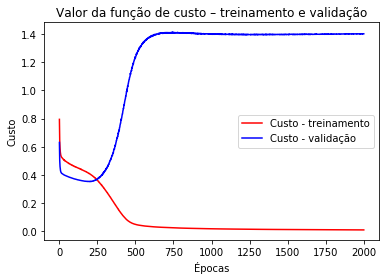

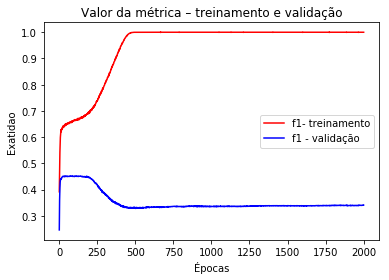

In [22]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

Normalized confusion matrix
[[0.76356215 0.23643785]
 [0.35704918 0.64295082]]
Normalized confusion matrix
[[0.7664564  0.2335436 ]
 [0.35967213 0.64032787]]
Normalized confusion matrix
[[0.76897959 0.23102041]
 [0.36295082 0.63704918]]
Normalized confusion matrix
[[0.77128015 0.22871985]
 [0.36655738 0.63344262]]
Normalized confusion matrix
[[0.77332096 0.22667904]
 [0.36819672 0.63180328]]
Normalized confusion matrix
[[0.77569573 0.22430427]
 [0.37114754 0.62885246]]
Normalized confusion matrix
[[0.77762523 0.22237477]
 [0.37311475 0.62688525]]
Normalized confusion matrix
[[0.77951763 0.22048237]
 [0.37540984 0.62459016]]
Normalized confusion matrix
[[0.78155844 0.21844156]
 [0.37704918 0.62295082]]
Normalized confusion matrix
[[0.78330241 0.21669759]
 [0.37836066 0.62163934]]
Normalized confusion matrix
[[0.7851577  0.2148423 ]
 [0.37934426 0.62065574]]
Normalized confusion matrix
[[0.78653061 0.21346939]
 [0.38229508 0.61770492]]
Normalized confusion matrix
[[0.78827458 0.21172542]

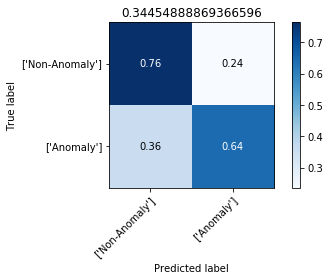

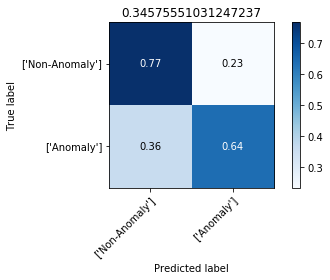

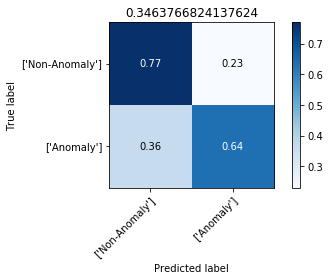

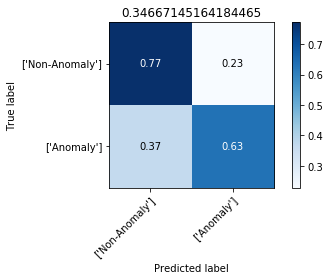

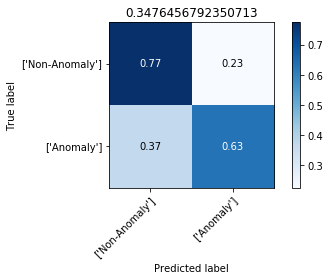

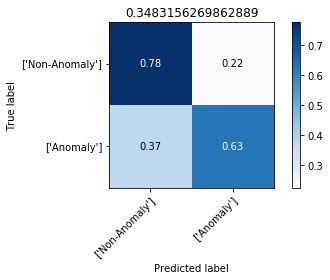

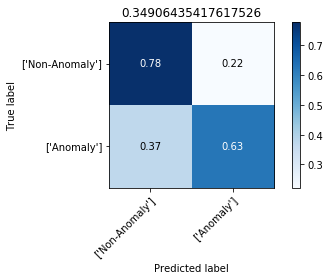

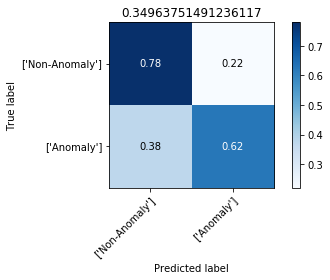

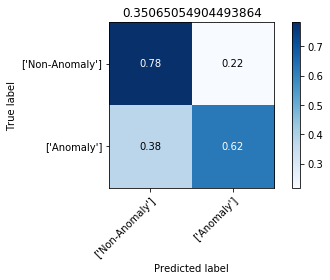

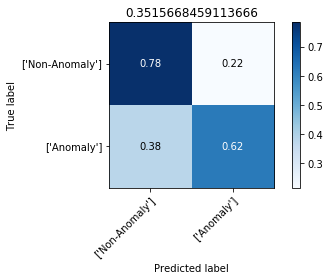

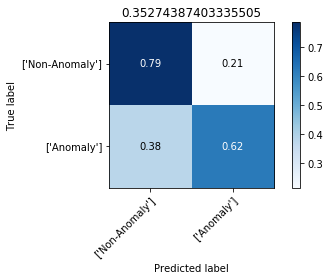

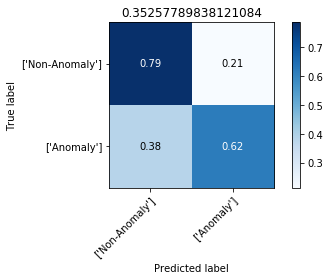

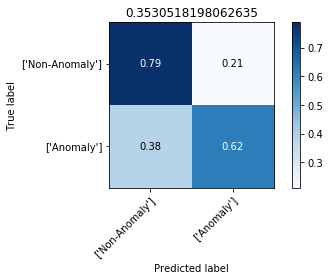

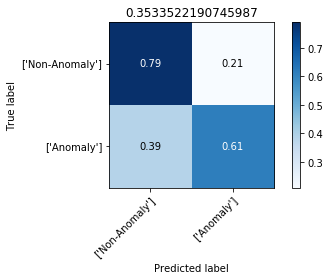

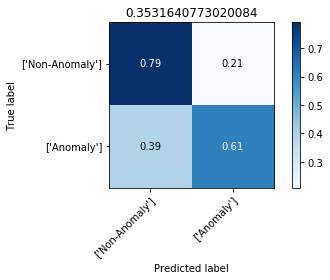

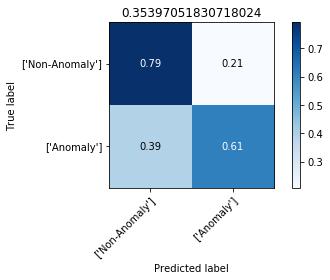

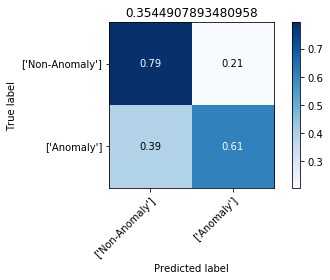

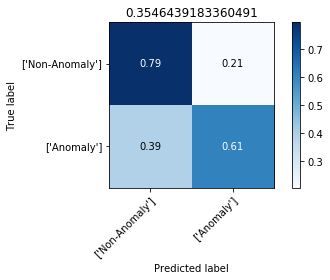

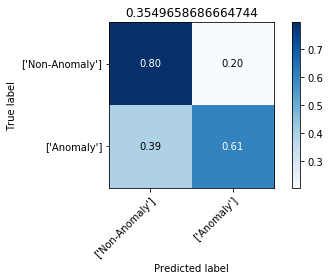

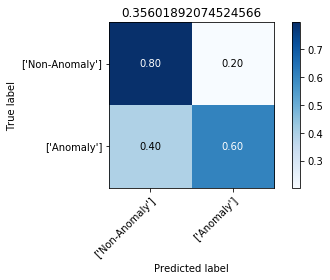

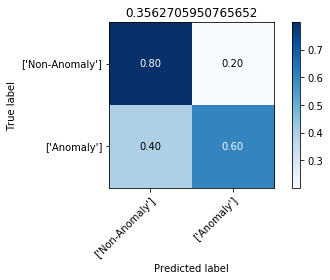

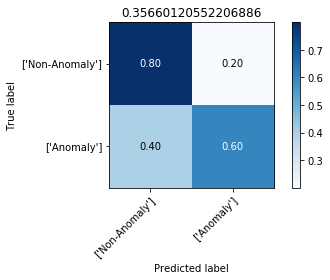

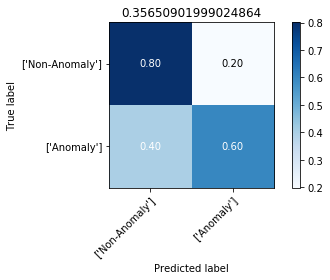

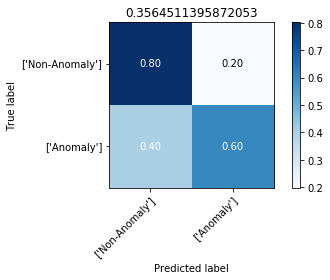

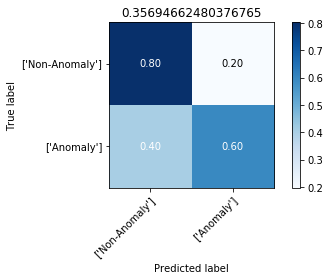

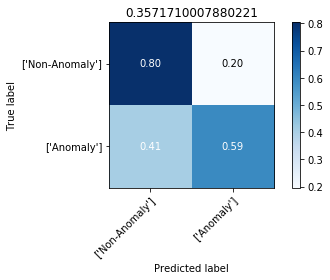

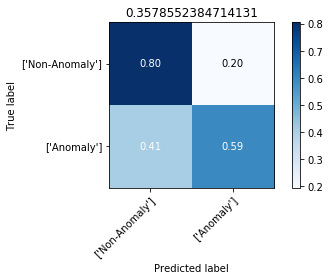

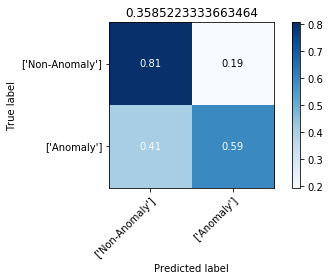

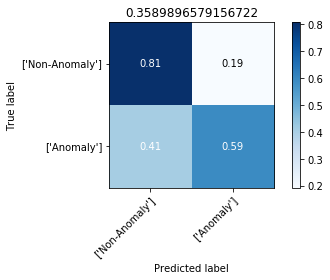

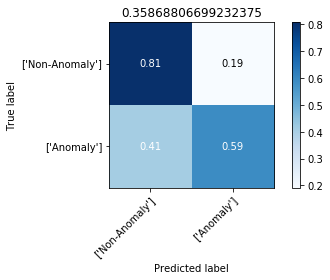

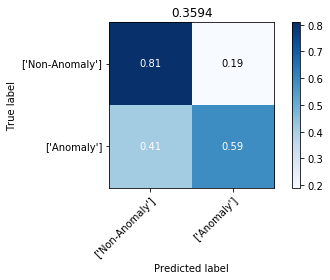

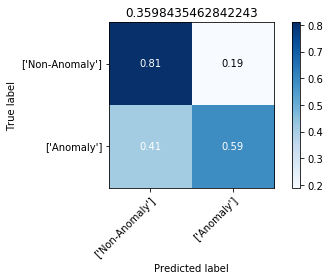

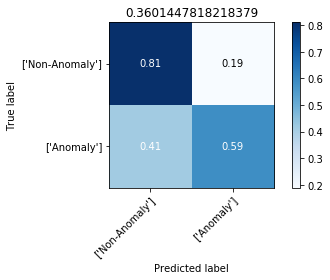

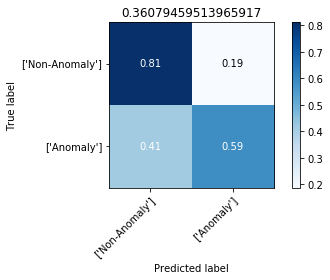

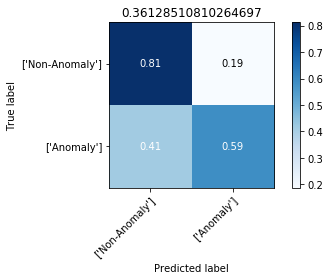

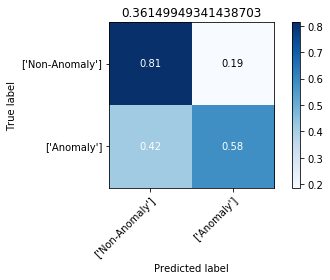

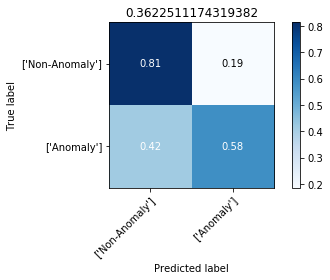

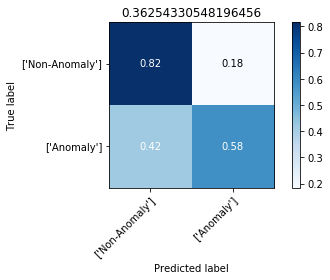

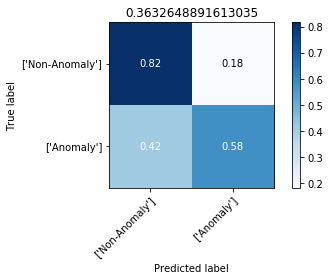

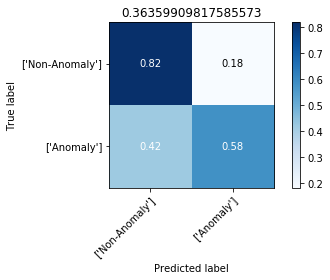

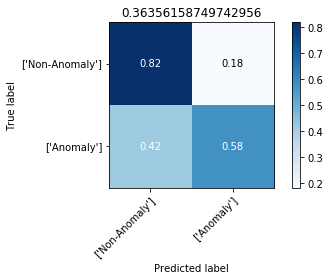

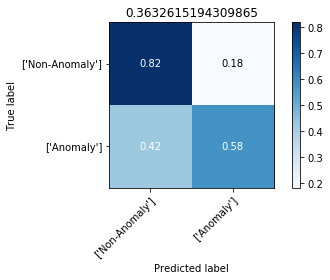

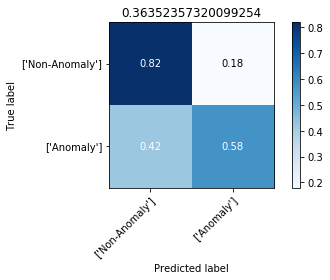

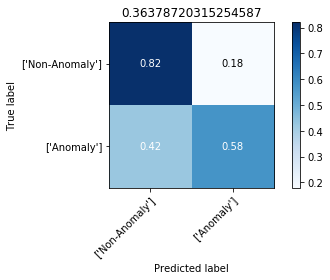

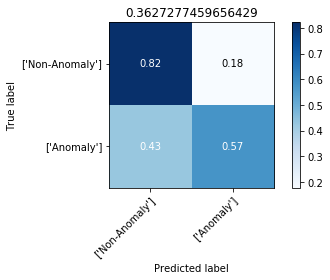

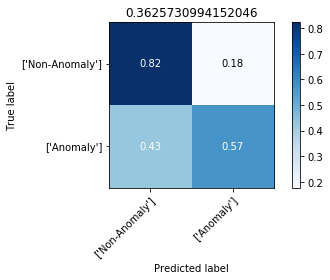

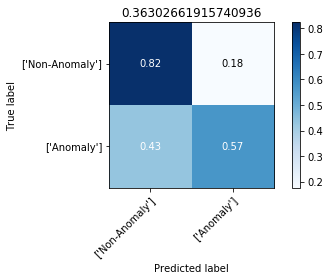

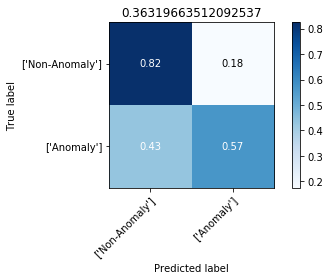

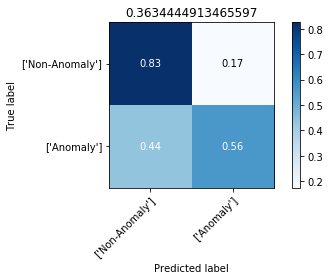

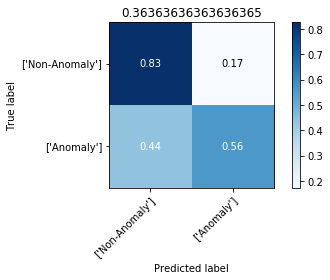

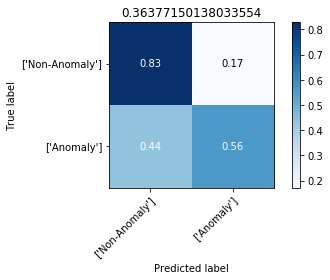

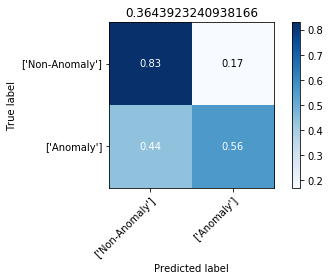

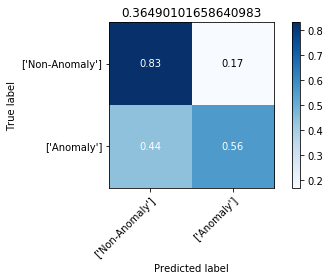

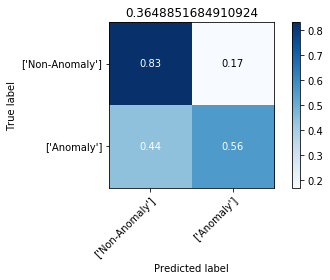

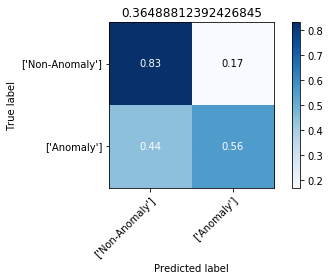

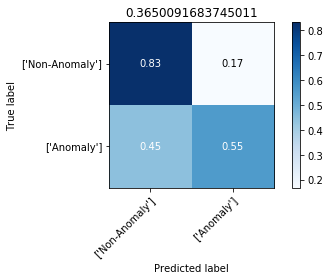

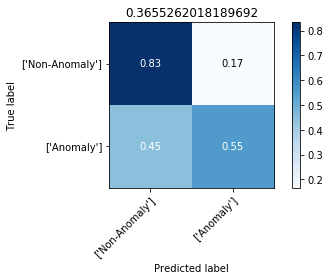

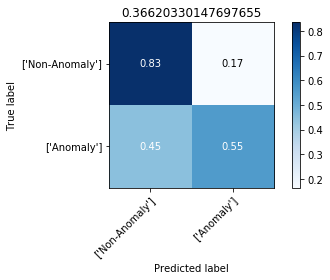

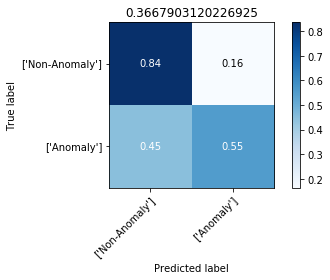

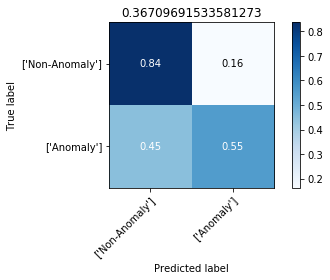

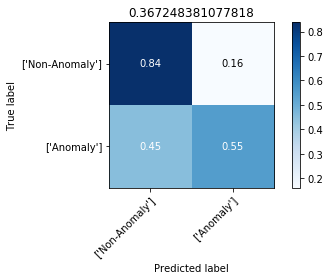

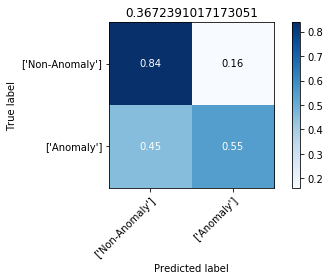

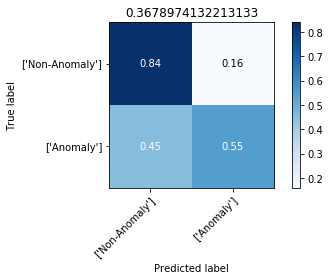

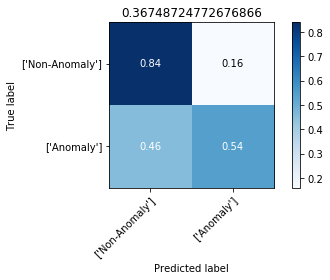

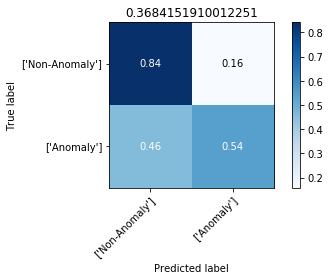

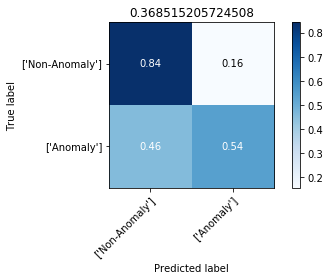

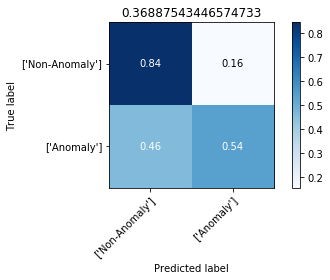

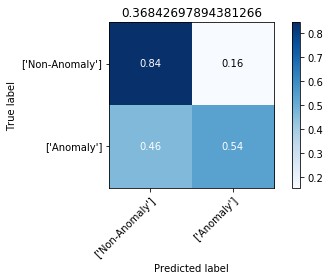

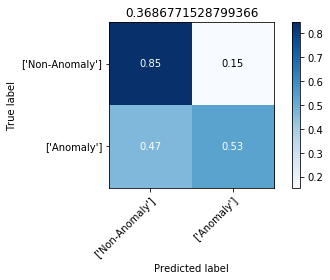

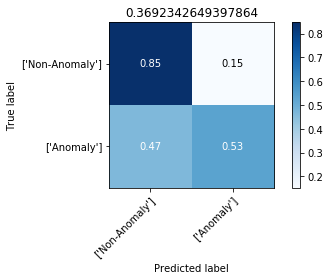

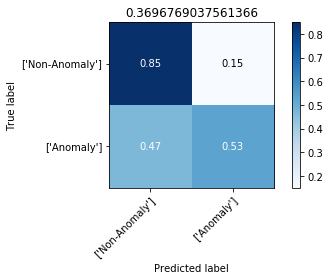

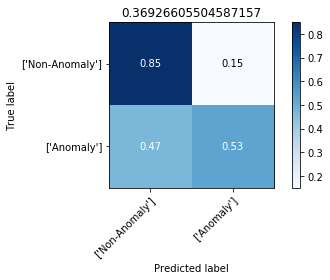

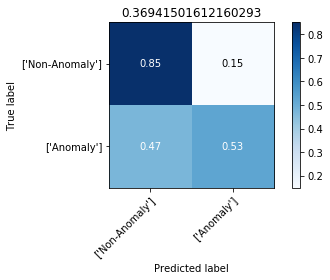

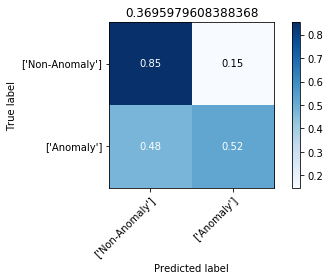

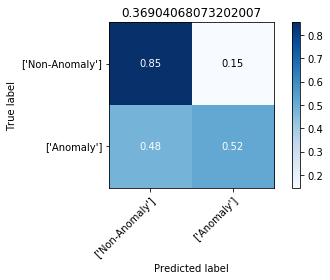

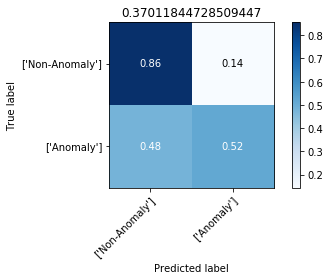

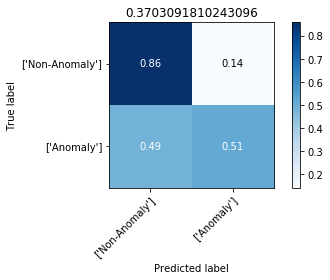

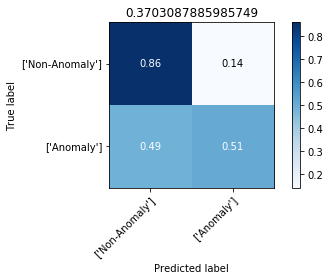

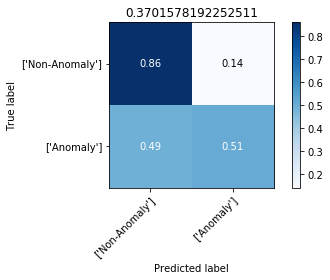

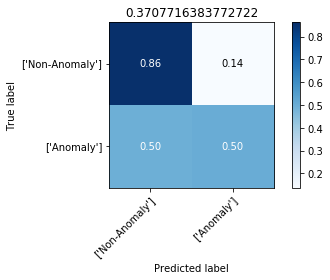

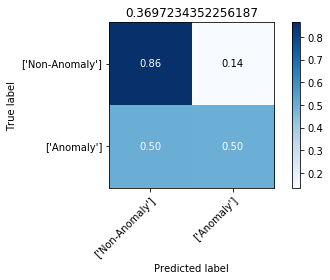

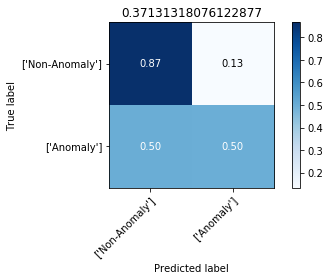

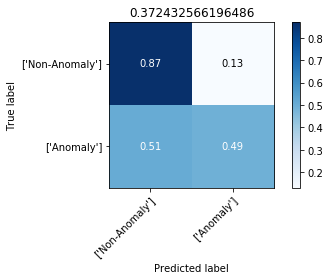

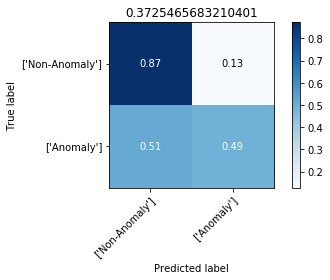

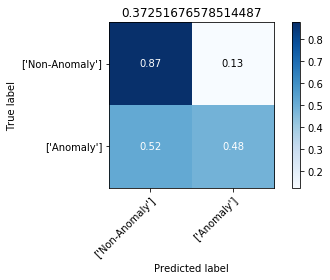

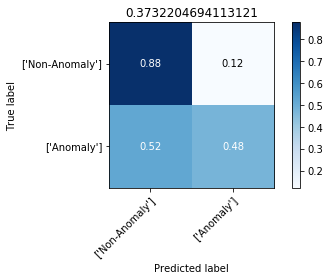

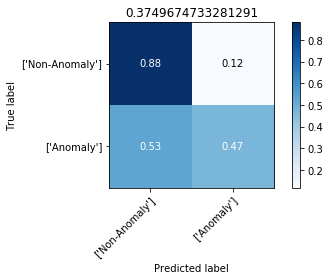

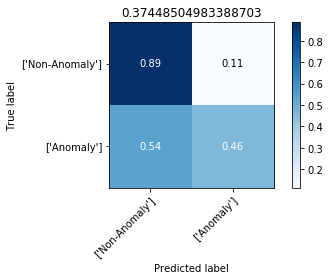

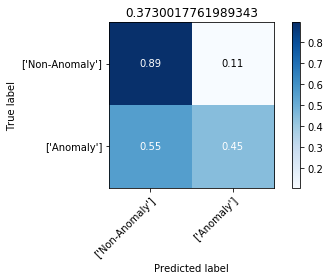

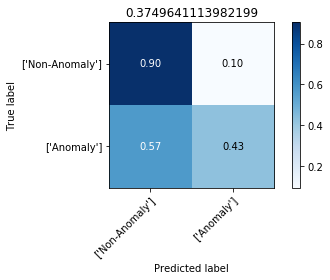

In [23]:
prob = np.ravel(model.predict(x_data[1]))
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[1],prob,threshold_list)

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[1], yprob[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00]
 [7.17257208e-05 9.99928274e-01]]
Normalized confusion matrix
[[0.88144712 0.11855288]
 [0.52754098 0.47245902]]
Normalized confusion matrix
[[0.87711014 0.12288986]
 [0.54958146 0.45041854]]


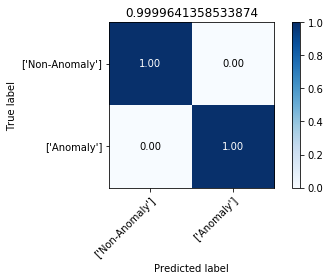

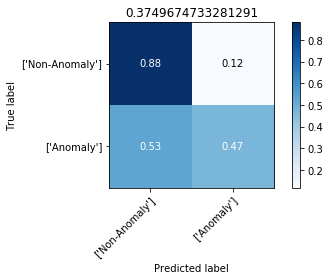

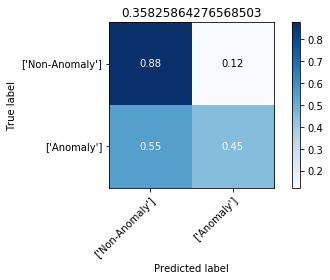

In [24]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])),
                                   threshold_list[f1.index(max(f1))]))

for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)

In [25]:
K.clear_session()

In [26]:
model = models.Sequential()
model.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,),
                        kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [27]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model2.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model2.fit(x_data[0],y_data[0],epochs = 2000, validation_data =(x_data[1],y_data[1]),verbose = 0)

NameError: name 'model2' is not defined

In [ ]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [ ]:
prob = np.ravel(model.predict(x_data[1]))
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[1],prob,threshold_list)

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[1], yprob[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [ ]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])),
                                   threshold_list[f1.index(max(f1))]))

for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)

In [ ]:
K.clear_session()

In [ ]:
model = models.Sequential()
model.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))
model.summary()

In [ ]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(x_data[0],y_data[0],epochs = 2000, validation_data =(x_data[1],y_data[1]),verbose = 0)

In [ ]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [ ]:
prob = np.ravel(model.predict(x_data[1]))
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[1],prob,threshold_list)

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[1], yprob[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [ ]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])),
                                   threshold_list[f1.index(max(f1))]))

for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)

In [ ]:
K.clear_session()

In [ ]:
model = models.Sequential()
model.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.1))
model.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))
model.summary()

In [ ]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(x_data[0],y_data[0],epochs = 2000, validation_data =(x_data[1],y_data[1]),verbose = 0)

In [ ]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [ ]:
prob = np.ravel(model.predict(x_data[1]))
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[1],prob,threshold_list)

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[1], yprob[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [ ]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])),
                                   threshold_list[f1.index(max(f1))]))

for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)

In [ ]:
K.clear_session()

In [ ]:
model = models.Sequential()
model.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.01)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))
model.summary()

In [ ]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(x_data[0],y_data[0],epochs = 2000, validation_data =(x_data[1],y_data[1]),verbose = 0)

In [ ]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [ ]:
prob = np.ravel(model.predict(x_data[1]))
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[1],prob,threshold_list)

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[1], yprob[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [ ]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])),
                                   threshold_list[f1.index(max(f1))]))

for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)

In [ ]:
K.clear_session()

In [ ]:
model = models.Sequential()
model.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))
model.summary()

In [ ]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(x_data[0],y_data[0],epochs = 2000, validation_data =(x_data[1],y_data[1]),verbose = 0)

In [ ]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [ ]:
prob = np.ravel(model.predict(x_data[1]))
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[1],prob,threshold_list)

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[1], yprob[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [ ]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])),
                                   threshold_list[f1.index(max(f1))]))

for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Non-Anomaly'],['Anomaly']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)